In [1]:
import sys
from brahma_analysis import *
from scipy.interpolate import interp1d
sys.path.append('/home/yja6qa/arepo_package/')

import arepo_package
import scipy.interpolate
import h5py
import os
import numpy as np
import plotting
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d

%matplotlib inline
radiative_efficiency=0.2

In [2]:
TNGpath='/standard/torrey-group/IllustrisTNG/Runs/L75n1820TNG'
basePath = TNGpath
snap_num=99 # z=0
hdr  = il.groupcat.loadHeader(TNGpath, snap_num)
h = hdr['HubbleParam'] ## load in h from the header
box_size = hdr["BoxSize"]
redshift = hdr['Redshift']

In [3]:
fields=['SubhaloLenType']
Subhalo_lengths = il.groupcat.loadSubhalos(basePath,snap_num,fields=fields)

SubhaloBHLen = Subhalo_lengths[:,5] # Number of BHs in each subhalo
SubhaloStarsLen = Subhalo_lengths[:,4] # Number of Stars in each subhalo
SubhaloIndices = np.arange(0,len(SubhaloBHLen)) # Indices of subhalos
mask1 = np.logical_and(SubhaloBHLen>0,SubhaloStarsLen>1000)  # Only subhalos with a BH and with 1000 stars
Desired_subhalos = SubhaloIndices[mask1]

In [66]:
subhalo_id = 10 # Desired_subhalos[50]
kpc2km = 3.0857e16
Subhaloprops = il.groupcat.loadSubhalos(basePath,snap_num,fields=['SubhaloPos','SubhaloVel'])
fields = ['Masses','Coordinates','Velocities','Potential']
Star_Props = il.snapshot.loadSubhalo(basePath, snap_num, id=subhalo_id, partType=4, fields=fields)

Coordinates,Velocities,Potentials = Center_subhalo(Star_Props,Subhaloprops,box_size,redshift,h,subhalo_id=subhalo_id)

pos,grad,ratio2,negids,rcs = kinematic_decomp_e(Coordinates,Velocities,Potentials)

e_bind = 0.5*np.linalg.norm(np.array(Velocities)**2,axis=1) + Potentials

# Normalizing to max binding energy
e_bind_norm = e_bind/np.abs(np.min(e_bind))

pos /= kpc2km

866.0 732414401.000011
567.75 732414102.750011
478.75 732414013.750011
441.25 732413976.250011
393.5 732413928.500011
Nonzero rcs: 255296 Skipped stars: 5


In [43]:
np.max(Potentials),np.min(Potentials)

(-1449145.9, -1586332.2)

In [44]:
r = np.sqrt(Coordinates[:,0]**2 + Coordinates[:,1]**2)
np.max(r/kpc2km)

84.36170106090864

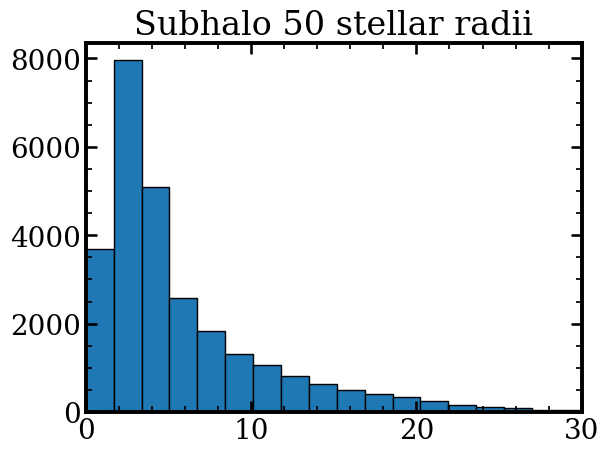

In [54]:
plt.hist(r/kpc2km,bins=50,edgecolor='black')
plt.xlim(0,30)
plt.title('Subhalo {} stellar radii'.format(subhalo_id))
plt.savefig('Plots/Subhalo_{}_radii'.format(subhalo_id))

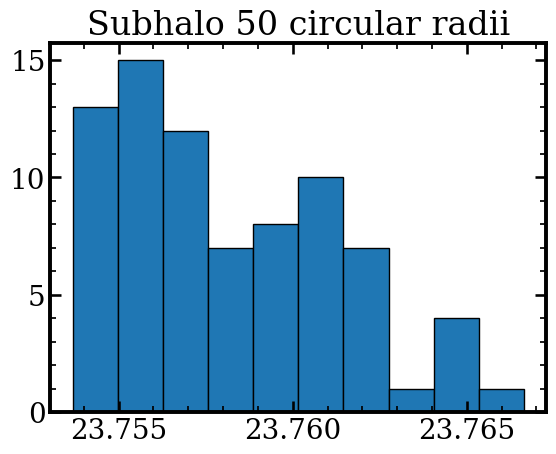

In [55]:
plt.hist(np.array(rcs)/kpc2km,edgecolor='black')
plt.title('Subhalo {} circular radii'.format(subhalo_id))
plt.savefig('Plots/Subhalo_{}_rcirc'.format(subhalo_id))

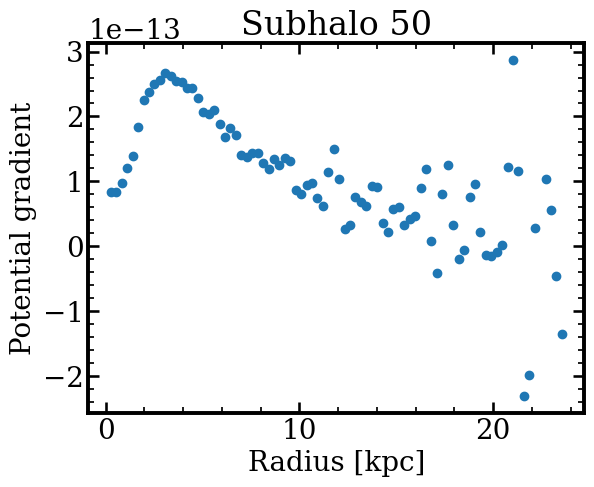

In [56]:
plt.scatter(pos,grad)
plt.xlabel("Radius [kpc]")
plt.ylabel("Potential gradient")
plt.title('Subhalo {}'.format(subhalo_id))
plt.savefig('Plots/Subhalo_{}_gradphi_r'.format(subhalo_id))

In [67]:
mask = (ratio2 < 25) & (ratio2 > -25) & (~np.isnan(ratio2))
ratio2 = ratio2[mask]
Velocities = Velocities[mask]

In [68]:
disks = [(ratio2[i] > 0.5) & (ratio2[i] < 1.3) for i in range(len(ratio2))]
bulges = [ratio2[i] < 0.5 for i in range(len(ratio2))]
disk_vel = Velocities[disks]
bulge_vel = Velocities[bulges]

In [69]:
disk_vel_3d = np.sqrt(disk_vel[:,0]**2 + disk_vel[:,1]**2 + disk_vel[:,2]**2 )
bulge_vel_3d = np.sqrt(bulge_vel[:,0]**2 + bulge_vel[:,1]**2 + bulge_vel[:,2]**2 )

print("Disk sigma:",np.std(disk_vel_3d),"Bulge sigma:",np.std(bulge_vel_3d))

Disk sigma: 82.2716 Bulge sigma: 122.64746


In [70]:
Vel3d = np.linalg.norm(Velocities,axis=1)

In [71]:
np.std(Vel3d)

102.76016

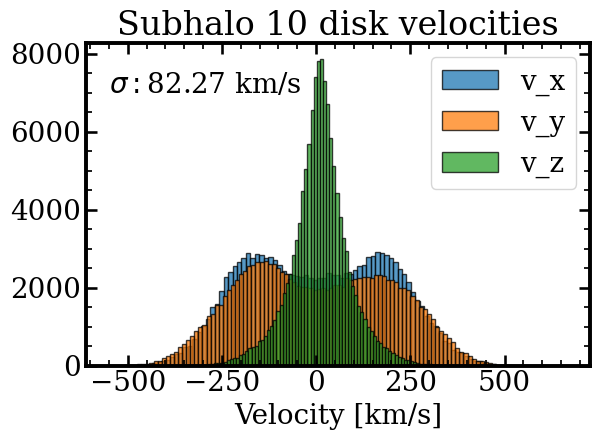

In [54]:
plt.hist(disk_vel[:,0],bins=100,edgecolor='black',label = 'v_x',alpha=0.75)
plt.hist(disk_vel[:,1],bins=100,edgecolor='black',label = 'v_y',alpha=0.75)
plt.hist(disk_vel[:,2],bins=100,edgecolor='black',label = 'v_z',alpha=0.75)

plt.text(-550,7000,f"$\sigma:${np.std(disk_vel_3d):.2f} km/s")
plt.legend()
plt.title("Subhalo {} disk velocities".format(subhalo_id))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_vel_disk.png'.format(subhalo_id))

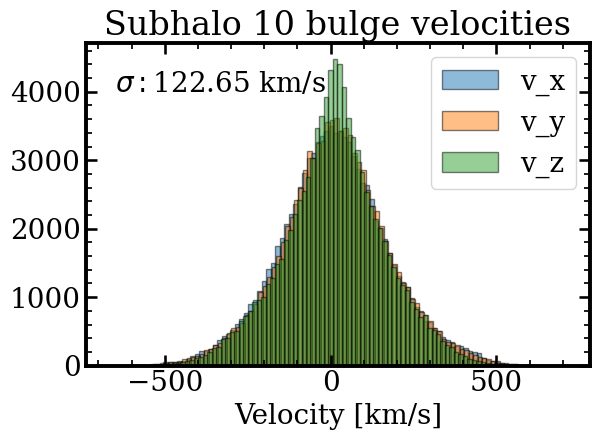

In [55]:
plt.hist(bulge_vel[:,0],bins=100,edgecolor='black',label = 'v_x',alpha=0.5)
plt.hist(bulge_vel[:,1],bins=100,edgecolor='black',label = 'v_y',alpha=0.5)
plt.hist(bulge_vel[:,2],bins=100,edgecolor='black',label = 'v_z',alpha=0.5)

plt.text(-650,4000,f"$\sigma:${np.std(bulge_vel_3d):.2f} km/s")
plt.legend()
plt.title("Subhalo {} bulge velocities".format(subhalo_id))
plt.xlabel("Velocity [km/s]")
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_vel_bulge.png'.format(subhalo_id))

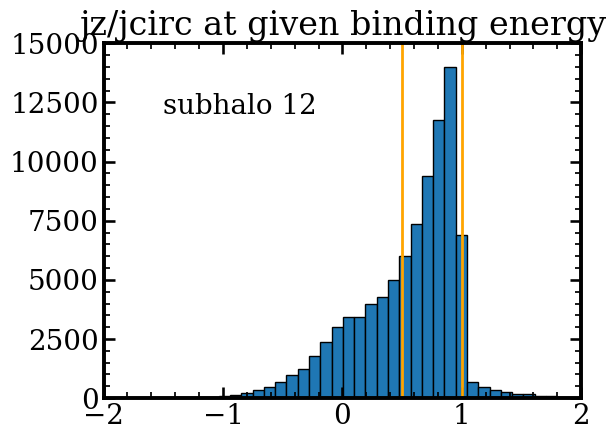

In [38]:
plt.hist(ratio2,bins=500,edgecolor='black')
plt.vlines([0.5,1],0,20000,color = 'orange',lw=2)
plt.ylim(0,15000)
plt.xlim(-2,2)
plt.title("jz/jcirc at given binding energy")
plt.text(-1.5,12000,'subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/Subhalo_{}_jz_jcirc_e.png'.format(subhalo_id))

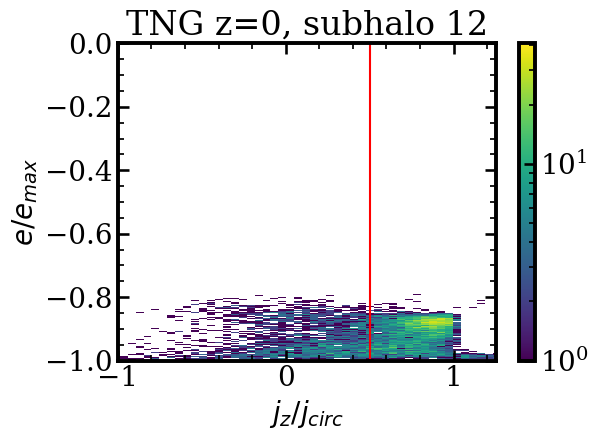

In [27]:
fig,ax=plt.subplots()

no_nans=~np.isnan(ratio2)
counts1, xedges1, yedges1, im1 = ax.hist2d(ratio2,e_bind_norm[mask],norm='log',bins=(1000,1000))

fig.colorbar(im1, ax=ax)
# ax.hlines([0.7,1.3],0,100,color='orange',lw=2,ls = '--')
# ax.hlines(1,0,100,color='orange',lw=2)
ax.vlines(0.5,-1,0,color='red')
plt.xlim(-1,1.25)
plt.ylim(-1,0)
plt.xlabel('$j_z/j_{circ}$')
plt.ylabel('$e/e_{max}$')
plt.title('TNG z=0, subhalo {}'.format(subhalo_id))
plt.tight_layout()
plt.savefig('Plots/TNG_subhalo_{}_emax_jz.png'.format(subhalo_id))

In [40]:
disks = [(ratio2[i] > 0.5) & (ratio2[i] < 1.3) for i in range(len(ratio2))]
bulges = [ratio2[i] < 0.5 for i in range(len(ratio2))]

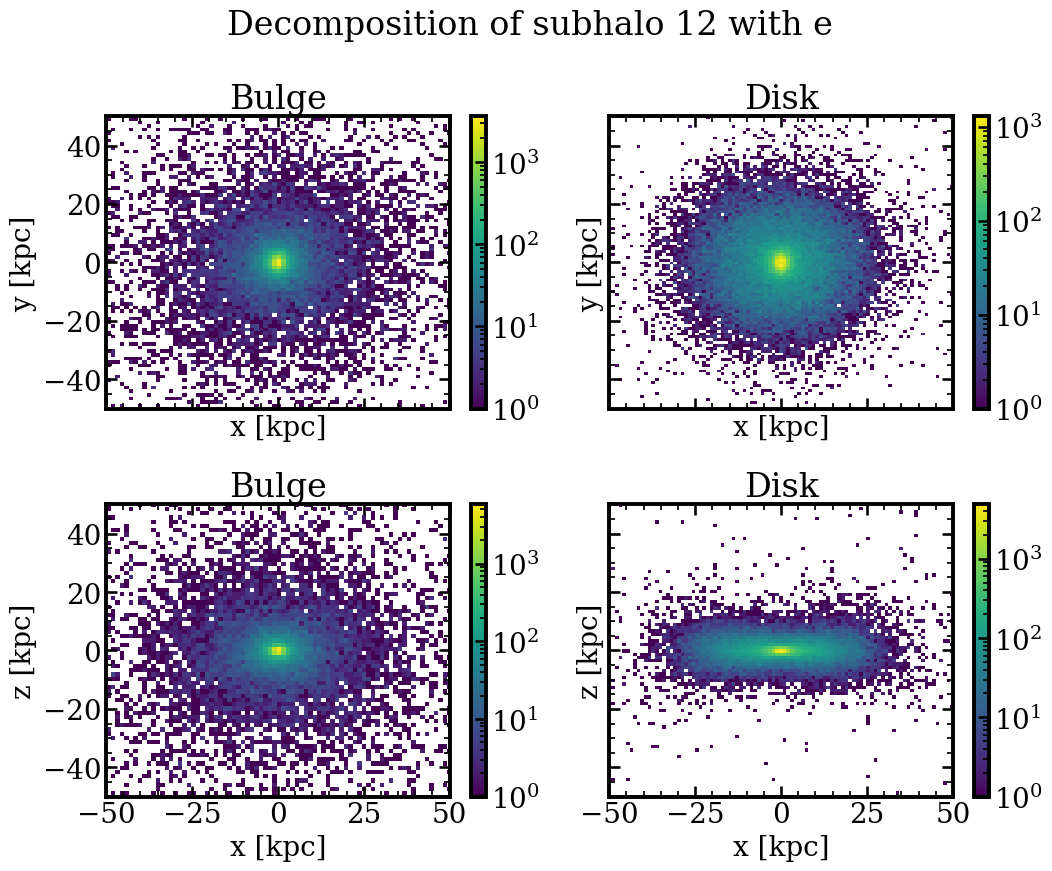

In [41]:
Coord = Coordinates[mask]/kpc2km
Bulge = Coord[bulges]
Disk = Coord[disks]

fig,axs=plt.subplots(2,2,figsize = (11,9),sharex=True,sharey=True)

counts1, xedges1, yedges1, im1 = axs[0,0].hist2d(Bulge[:,0],Bulge[:,1],norm='log',bins=300)
counts2, xedges2, yedges2, im2 = axs[0,1].hist2d(Disk[:,0],Disk[:,1],norm='log',bins=300)
axs[0,0].set_title('Bulge')
axs[0,1].set_title('Disk')
axs[0,0].set_xlabel('x [kpc]')
axs[0,1].set_xlabel('x [kpc]')
axs[0,0].set_ylabel('y [kpc]')
axs[0,1].set_ylabel('y [kpc]')

counts3, xedges3, yedges3, im3 = axs[1,0].hist2d(Bulge[:,0],Bulge[:,2],norm='log',bins=300)
counts4, xedges4, yedges4, im4 = axs[1,1].hist2d(Disk[:,0],Disk[:,2],norm='log',bins=300)

axs[1,0].set_title('Bulge')
axs[1,1].set_title('Disk')
axs[1,0].set_xlabel('x [kpc]')
axs[1,1].set_xlabel('x [kpc]')
axs[1,0].set_ylabel('z [kpc]')
axs[1,1].set_ylabel('z [kpc]')

for ax in axs.flatten():
    ax.set_xlim(-50,50)
    ax.set_ylim(-50,50)

fig.colorbar(im1, ax=axs[0,0])
fig.colorbar(im2, ax=axs[0,1])
fig.colorbar(im3, ax=axs[1,0])
fig.colorbar(im4, ax=axs[1,1])

fig.suptitle('Decomposition of subhalo {} with e'.format(subhalo_id))

fig.tight_layout()
fig.savefig('Plots/Subhalo_{}_decomp_0.5_e.png'.format(subhalo_id))